In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
import chess.pgn
import numpy as np

/Users/ar-yukoh.shimizu/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
piece_values = {
    "p": 1,
    "n": 3,
    "b": 3,
    "r": 5,
    "q": 9,
    "k": 1000,
    "P": -1,
    "N": -3,
    "B": -3,
    "R": -5,
    "Q": -9,
    "K": -1000,
}

def createStateObj(board):
    # convert state into a 8x8x12 tensor
    state = np.zeros(774) # 8 * 8 * 12 + 5
    net_piece_value = 0

    for square, piece in board.piece_map().items():
        for square, piece in board.piece_map().items():
            net_piece_value += piece_values[str(piece)]
            if piece.color == chess.WHITE:
                state[square * 12 + piece.piece_type - 1] = 1
            else:
                state[square * 12 + piece.piece_type + 5] = 1

    # flatten state
    state = state.flatten()

    # append the 5 states above
    p1_can_castle_queenside = board.has_queenside_castling_rights(chess.WHITE)
    p1_can_castle_kingside = board.has_kingside_castling_rights(chess.WHITE)
    p2_can_castle_queenside = board.has_queenside_castling_rights(chess.BLACK)
    p2_can_castle_kingside = board.has_kingside_castling_rights(chess.BLACK)
    turn = board.turn

    state[768] = p1_can_castle_queenside
    state[769] = p1_can_castle_kingside
    state[770] = p2_can_castle_queenside
    state[771] = p2_can_castle_kingside
    state[772] = net_piece_value
    state[773] = float(turn)
    
    return state


start = 0
flag = 0

def createData(start, n_data=10000):
    with open("DATABASE4U_CLEANED.pgn", "r") as rf:
        for i in range(start):
            game = chess.pgn.read_game(rf)

        X = []
        y = []

        for i in range(start, start + n_data):
            game = chess.pgn.read_game(rf)
            if game is None:
                flag = 1
                break

            if game.headers["Result"] == '1/2-1/2':
                win = 0
            elif game.headers["Result"] == '1-0':
                win = 1
            elif game.headers["Result"] == '0-1':
                win = -1
            else:
                print("Error: Unexpected result string" + game.headers["Result"])
                continue

            board = game.board()

            lst = list(game.mainline_moves())
            l_lst = len(lst)
            r1, r2 = random.randint(0, l_lst), random.randint(0, l_lst)
            r1, r2 = min(r1, r2), max(r1, r2)

            for i in range(r1):
                board.push(lst[i])
            X.append(createStateObj(board))
            y.append(win)

            if r1 == r2:
                continue

            for i in range(r1, r2):
                board.push(lst[i])
            X.append(createStateObj(board))
            y.append(win)
    
    data = list(zip(X, y))
    random.shuffle(data)
    X, y = zip(*data)

    return X, y

In [3]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(774, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [4]:
# hyperparameters
lr = 0.0001
num_epochs = 100

In [5]:
class DataLoader:
    def __init__(self, start=0):
        self.start = start

    def _create_data(self, step):
        if os.path.exists(f"data/{self.start}_{self.start+step}X.npy") and os.path.exists(
            f"data/{self.start}_{self.start+step}y.npy"
        ):
            X = np.load(f"data/{self.start}_{self.start+step}X.npy")
            y = np.load(f"data/{self.start}_{self.start+step}y.npy")

        else:
            X, y = createData(self.start, step)
            np.save(f"data/{self.start}_{self.start+step}X.npy", X)
            np.save(f"data/{self.start}_{self.start+step}y.npy", y)

        return X, y

    def get_data(self, step=10000):
        X, y = self._create_data(step)
        self.start += step

        return list(zip(X, y))


trainLoader = DataLoader()

In [57]:
net = MyNetwork()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

# Define the loss function
criterion = nn.MSELoss()

# Train the network
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} of {num_epochs}")
    running_loss = 0.0
    for i, data in enumerate(trainLoader.get_data()):
        # Get the inputs
        inputs, labels = data

        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    # save model into an .h5 file every 10 epochs
    if epoch % 10 == 9:
        torch.save(net.state_dict(), f"model_{epoch}.h5")

Error: Unexpected result string*
[1,   100] loss: 0.913
[1,   200] loss: 0.900
[1,   300] loss: 0.938
[1,   400] loss: 0.871
[1,   500] loss: 0.867
[1,   600] loss: 0.821
[1,   700] loss: 0.860
[1,   800] loss: 0.889
[1,   900] loss: 0.905
[1,  1000] loss: 0.863
[1,  1100] loss: 0.831
[1,  1200] loss: 0.871
[1,  1300] loss: 0.950
[1,  1400] loss: 0.856
[1,  1500] loss: 0.813
[1,  1600] loss: 0.851
[1,  1700] loss: 0.873
[1,  1800] loss: 0.850
[1,  1900] loss: 0.881
Error: Unexpected result string*
Error: Unexpected result string*
Error: Unexpected result string*
[2,   100] loss: 0.814
[2,   200] loss: 0.826
[2,   300] loss: 0.854
[2,   400] loss: 0.840
[2,   500] loss: 0.831
[2,   600] loss: 0.836
[2,   700] loss: 0.847
[2,   800] loss: 0.799
[2,   900] loss: 0.791
[2,  1000] loss: 0.817
[2,  1100] loss: 0.833
[2,  1200] loss: 0.793
[2,  1300] loss: 0.824
[2,  1400] loss: 0.857
[2,  1500] loss: 0.769
[2,  1600] loss: 0.848
[2,  1700] loss: 0.798
[2,  1800] loss: 0.771
[2,  1900] loss: 

KeyboardInterrupt: 

In [54]:
trainLoader = DataLoader(0)
a = trainLoader.get_data(10)

for i, data in enumerate(a):
    # Get the inputs
    inputs, labels = data

    # convert inputs and labels into torch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Print statistics
    running_loss += loss.item()
    if i % 100 == 99:
        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0

# save model into an .h5 file every 10 epochs
if epoch % 10 == 9:
    torch.save(net.state_dict(), f"model_{epoch}.h5")

/Users/ar-yukoh.shimizu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [10]:
model = MyNetwork()

model.load_state_dict(torch.load("model_109.pt"))

<All keys matched successfully>

In [11]:
with open("sample02.pgn", "r") as f:
    game = chess.pgn.read_game(f)

In [13]:
lst = list(game.mainline_moves())
board = game.board()

for i in range(10):
    board.push(lst[i])

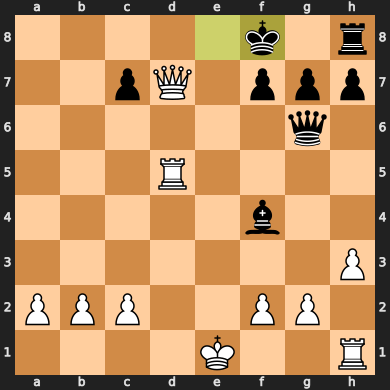

In [35]:
for i in range(38, 40):
    board.push(lst[i])

board

In [36]:
with torch.no_grad():
    print(model(torch.tensor(createStateObj(board), dtype=torch.float32)))

tensor([0.1723])


In [37]:
board.legal_moves

<LegalMoveGenerator at 0x126f24970 (Qe8+, Qd8#, Qc8+, Qxf7+, Qe7+, Qxc7, Qe6, Qd6+, Qc6, Qf5, Qb5, Qg4, Qa4, Rd6, Rh5, Rg5, Rf5, Re5, Rc5, Rb5, Ra5, Rd4, Rd3, Rd2, Rd1, Rh2, Rg1, Rf1, Ke2, Kf1, Kd1, O-O, h4, g3, f3, c3, b3, a3, g4, c4, b4, a4)>

In [39]:
list(board.legal_moves)

[Move.from_uci('d7e8'),
 Move.from_uci('d7d8'),
 Move.from_uci('d7c8'),
 Move.from_uci('d7f7'),
 Move.from_uci('d7e7'),
 Move.from_uci('d7c7'),
 Move.from_uci('d7e6'),
 Move.from_uci('d7d6'),
 Move.from_uci('d7c6'),
 Move.from_uci('d7f5'),
 Move.from_uci('d7b5'),
 Move.from_uci('d7g4'),
 Move.from_uci('d7a4'),
 Move.from_uci('d5d6'),
 Move.from_uci('d5h5'),
 Move.from_uci('d5g5'),
 Move.from_uci('d5f5'),
 Move.from_uci('d5e5'),
 Move.from_uci('d5c5'),
 Move.from_uci('d5b5'),
 Move.from_uci('d5a5'),
 Move.from_uci('d5d4'),
 Move.from_uci('d5d3'),
 Move.from_uci('d5d2'),
 Move.from_uci('d5d1'),
 Move.from_uci('h1h2'),
 Move.from_uci('h1g1'),
 Move.from_uci('h1f1'),
 Move.from_uci('e1e2'),
 Move.from_uci('e1f1'),
 Move.from_uci('e1d1'),
 Move.from_uci('e1g1'),
 Move.from_uci('h3h4'),
 Move.from_uci('g2g3'),
 Move.from_uci('f2f3'),
 Move.from_uci('c2c3'),
 Move.from_uci('b2b3'),
 Move.from_uci('a2a3'),
 Move.from_uci('g2g4'),
 Move.from_uci('c2c4'),
 Move.from_uci('b2b4'),
 Move.from_uci('